# OLS vs Bayesian Linear Regression 
By: William Duquette and Soham Changani

In [1]:
#Import necessary libraries
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sn
import matplotlib.pyplot as pyplot
import pymc3 as pm
from statsmodels.graphics.gofplots import qqplot 

#from pymc3 import traceplot

# Scipy for statistics
import scipy
from scipy.stats import norm
import theano

from arviz.utils import Numba
Numba.disable_numba()
Numba.numba_flag


import arviz as az #pymc3 plot functions use Arviz. Either command works. Ex: az.plot_posterior = pm.plot_posterior

The data set we are working with, Zagat, has data about $168$ Italian restaurants in New York and ratings customers provided for each restaurant's food, ambiance, etc., along with the average price. The question we are interested in answering: Is the average price of food at restaurants dependent on the average food rating? This will be done using Ordinary Least Squares (OLS) and Bayesian Linear Regression.

In [2]:
#Import Data
NYCData = "nyc.csv" 
NYCDf = pd.read_csv(NYCData)

NYCDf.drop(["Unnamed: 0", "X", "Case"], axis = 1, inplace = True)
NYCDf.set_index("Restaurant", inplace = True)
#NYCDf["Intercept"] = 1

NYCDf

,Price,Food,Decor,Service,East
Restaurant,,,,,
Daniella Ristorante,43,22,18,20,0
Tello's Ristorante,32,20,19,19,0
Biricchino,34,21,13,18,0
Bottino,41,20,20,17,0
Da Umberto,54,24,19,21,0
...,...,...,...,...,...
Baci,31,17,15,16,0
Puccini,26,20,16,17,0
Bella Luna,31,18,16,17,0


We first need to make a scatterplot to determine if linear regression is appropriate. Remember the question we are trying to answer is whether average price of food is dependent on the average food rating. So for this question, the restaurant's average price will be our response variable, and the food rating will be our explanatory variable. See code below to make needed scatterplot.

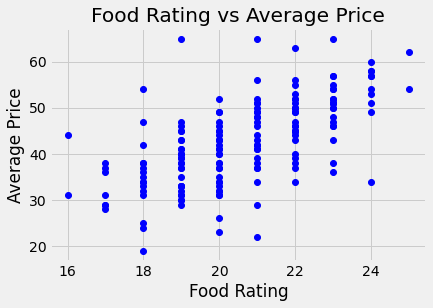

In [3]:
pyplot.style.use('fivethirtyeight')
pyplot.plot(NYCDf["Food"],NYCDf["Price"], "bo")
pyplot.xlabel("Food Rating")
pyplot.ylabel("Average Price")
pyplot.title("Food Rating vs Average Price")
pyplot.show()

## Ordinary Least Squares Regression

Now that we can see the variables have a linear relationship we can continue with our analysis. First we must fit a OLS linear regression model. First, we must gather the data for our two variables and build our linear model. Next , we will build our linear model by using Numpy's lstsq tool. Below you can see the output the OLS linear model.

In [4]:
x = NYCDf["Food"]
y = NYCDf["Price"]

A = np.vstack([x, np.ones(len(x))]).T
model, SSE = np.linalg.lstsq(A, y, rcond=None)[:2]

print(f"""The values gathered from our data are {model[1]} for our intercept and {model[0]} for our slope.""")

The values gathered from our data are -17.83214855650661 for our intercept and 2.9389598143043676 for our slope.


Below is the residuals vs fitted, and QQ plot for our OLS linear model. This done to check the conditions of linear regression. As you can see the conditions of this model are met.

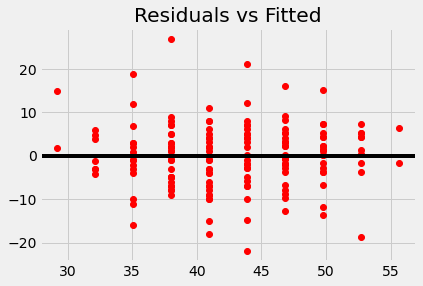

In [5]:
pyplot.plot(model[0]*x + model[1], y-(model[0]*x + model[1]), 'ro',label='Residuals')
pyplot.axhline(0,c='k')
pyplot.title("Residuals vs Fitted")
pyplot.show()

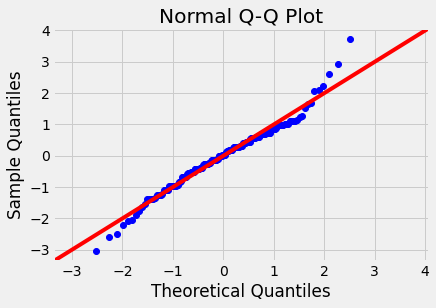

In [6]:
qqplot(y-(model[0]*x + model[1]),norm,fit=True,line="45") 
pyplot.title("Normal Q-Q Plot")
pyplot.show()

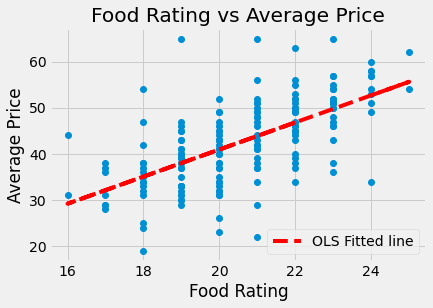

In [7]:
_ = pyplot.plot(x, y, 'o')
_ = pyplot.plot(x, model[1] + model[0]*x, 'r--', label='OLS Fitted line')
_ = pyplot.xlabel("Food Rating")
_ = pyplot.ylabel("Average Price")
_ = pyplot.title("Food Rating vs Average Price")
_ = pyplot.legend()
pyplot.show()

## Bayesian Linear Regression

We will now use the same data set, Zagat, and try to fit a linear regression model using Bayesian Statistics. The first example is where we use an informed prior i.e. we have an example where we already know something about the data. Let's say that we think the intercept and slope should be centred around 0 with a standard deviation of 5. We use the pymc3 package to create prior normal distributions. Then, we use the NUTS command; which uses No-U-Turn Sampling (a kind of Markov Chain Monte Carlo method) to estimate the steps for determining the posterior. Finally, we create the posterior distribution for the intercept, slope and standard deviation. The number of iterations can be changed from 100. Using more iterations is usually better for sampling. 

Warning: If the number of iterations is large, this code will take a long time to run.

### Informed Prior

In [8]:
with pm.Model() as linear_model_informed:
    # Intercept
    intercept = pm.Normal("Intercept", mu = 0, sd = 5)
    
    # Slope 
    slope = slope1 = pm.Normal("slope", mu = 0, sd = 5)
    
    # Standard deviation
    sigma = pm.HalfNormal("sigma", sd = 10)
    
    # Estimate of mean
    mean = intercept + slope * NYCDf["Food"]
    
    # Observed values
    Y_obs = pm.Normal('Y_obs', mu = mean, sd = sigma, observed = NYCDf["Price"].values)
    
    # Sampler
    step = pm.NUTS()

    # Posterior distribution
    linear_trace_informed = pm.sample(10000, step)

<ipython-input-8-a368d1427fd9>:21: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  linear_trace_informed = pm.sample(10000, step)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, slope, Intercept]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 33 seconds.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8786331764064411, but should be close to 0.8. Try to increase the number of tuning steps.


<ipython-input-9-59c378369b7d>:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(linear_trace_informed, figsize = (12, 12))
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\wjduq\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'slope'}>,
        <AxesSubplot:title={'center':'slope'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

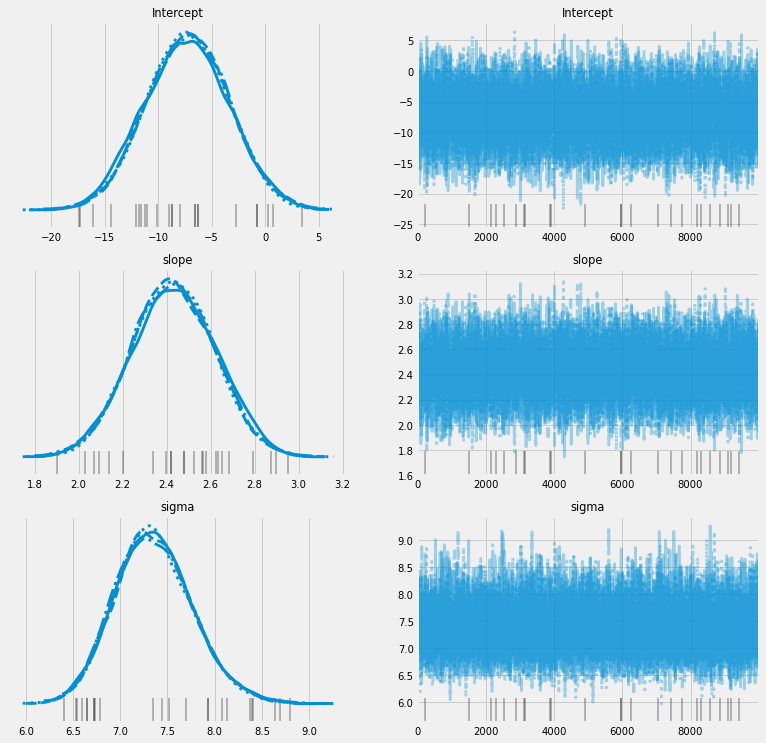

In [9]:
pm.traceplot(linear_trace_informed, figsize = (12, 12))

The traceplot above shows the different values that are sampled by the MCMC method. It peaks around the mean of the posterior distribution. The histograms below show the posterior distributions for intercept, coefficient and standard deviation. As you can see, the posterior was heavily affected by the prior. For example, the OLS model's intercept was -17.83 (the MLE of likelihood distribution for the intercept), but the mean for the intercept's posterior is -7.4. This extremely large shift is caused by our informed prior that has a mean of 0 with a relatively small standard deviation, meaning it will have a significant effect on the posterior.

Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\wjduq\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<AxesSubplot:title={'center':'Intercept'}>,
       <AxesSubplot:title={'center':'slope'}>,
       <AxesSubplot:title={'center':'sigma'}>], dtype=object)

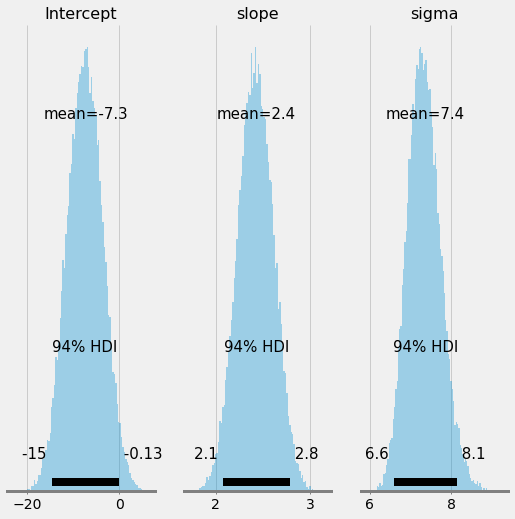

In [10]:
pm.plot_posterior(linear_trace_informed, figsize = (8, 8), kind = "hist")

Directly below you can see the original scatterplot with the possible posterior equations on it. Remember, the posterior is not the one "best" equation but rather a distribution. Below that , you can also see the "best" model built from the posterior compared to the OLS model. The "best" parameter values from the posterior was simply found by taking the mean of the posterior for the intercept and the slope. This is also known as the maximum of the posterior (MAP).

C:\Users\wjduq\anaconda3\lib\site-packages\pymc3\plots\posteriorplot.py:59: DeprecationWarning: The `plot_posterior_predictive_glm` function will migrate to Arviz in a future release. 
Keep up to date with `ArviZ <https://arviz-devs.github.io/arviz/>`_ for future updates.
  warnings.warn(


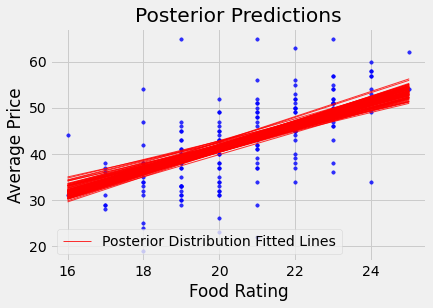

In [11]:
pm.plot_posterior_predictive_glm(linear_trace_informed, samples = 100, eval=np.linspace(16,25, 100), linewidth = 1, 
                                 color = "red", alpha = 0.8, label = "Posterior Distribution Fitted Lines",
                                lm = lambda x, sample: sample["Intercept"] + sample["slope"] * x);
pyplot.scatter(NYCDf["Food"], y.values, s = 12, alpha = 0.8, c = "blue")
pyplot.title("Posterior Predictions")
pyplot.xlabel("Food Rating")
pyplot.ylabel("Average Price")
pyplot.legend()

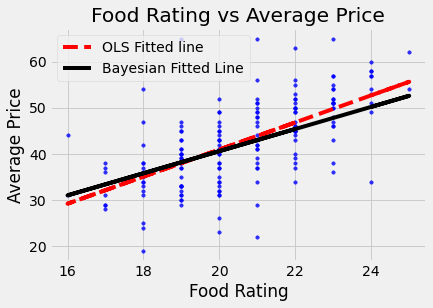

In [12]:
pyplot.scatter(NYCDf["Food"], y.values, s = 12, alpha = 0.8, c = "blue")
pyplot.plot(x, model[1] + model[0]*x, 'r--', label='OLS Fitted line')
pyplot.plot(x, -7.4 + 2.4*x, 'black', label='Bayesian Fitted Line')
pyplot.title("Food Rating vs Average Price")
pyplot.xlabel("Food Rating")
pyplot.ylabel("Average Price")
pyplot.legend()

We will now make a prediction using Bayesian regression and OLS regression for when the food rating is 23. The distribution below shows the posterior distribution given a food rating of $23,$ which seems to be centered around $48.7$. The red dashed vertical line represents the OLS predicted value.

In [13]:
bayes_prediction = linear_trace_informed["Intercept"] + linear_trace_informed["slope"] * 23

Text(0.5, 1.0, 'Posterior Prediction for Food Rating of 23')

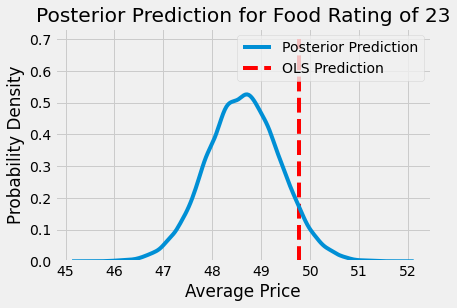

In [14]:
sn.kdeplot(bayes_prediction, label = 'Posterior Prediction')
pyplot.vlines(x = model[1] + model[0] * 23, ymin = 0, ymax = 0.7, label = 'OLS Prediction', colors = 'red', linestyles='--')
pyplot.legend()
pyplot.xlabel("Average Price")
pyplot.ylabel("Probability Density")
pyplot.title("Posterior Prediction for Food Rating of 23")

### Uninformed Prior

For the next part of Bayesian Linear Regression, we will make posterior distributions using prior distributions that do not have as much information. In order to make uninformed priors, we change the standard deviation for the intercept and coefficient to 100. A large standard deviation suggests that we are not sure about our prior values which is why our data has a greater effect on the posterior distribution. We use the same sampling method to generate the posterior distribution.

In [15]:
with pm.Model() as linear_model_uninformed:
    # Intercept
    intercept = pm.Normal("Intercept", mu = 0, sd = 100)
    
    # Slope 
    slope = slope1 = pm.Normal("slope", mu = 0, sd = 100)
    
    # Standard deviation
    sigma = pm.HalfNormal("sigma", sd = 10)
    
    # Estimate of mean
    mean = intercept + slope * NYCDf["Food"]
    
    # Observed values
    Y_obs = pm.Normal('Y_obs', mu = mean, sd = sigma, observed = NYCDf["Price"].values)
    
    # Sampler
    step = pm.NUTS()

    # Posterior distribution
    linear_trace_uninformed = pm.sample(10000, step)

<ipython-input-15-3c6de412f2d9>:21: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  linear_trace_uninformed = pm.sample(10000, step)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, slope, Intercept]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 44 seconds.
The acceptance probability does not match the target. It is 0.8947299070416422, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8954435715834599, but should be close to 0.8. Try to increase the number of tuning steps.


The traceplot below shows the different values that are sampled by the MCMC method.

<ipython-input-16-4ffee586d9a2>:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(linear_trace_uninformed, figsize = (12, 12))
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\wjduq\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'slope'}>,
        <AxesSubplot:title={'center':'slope'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

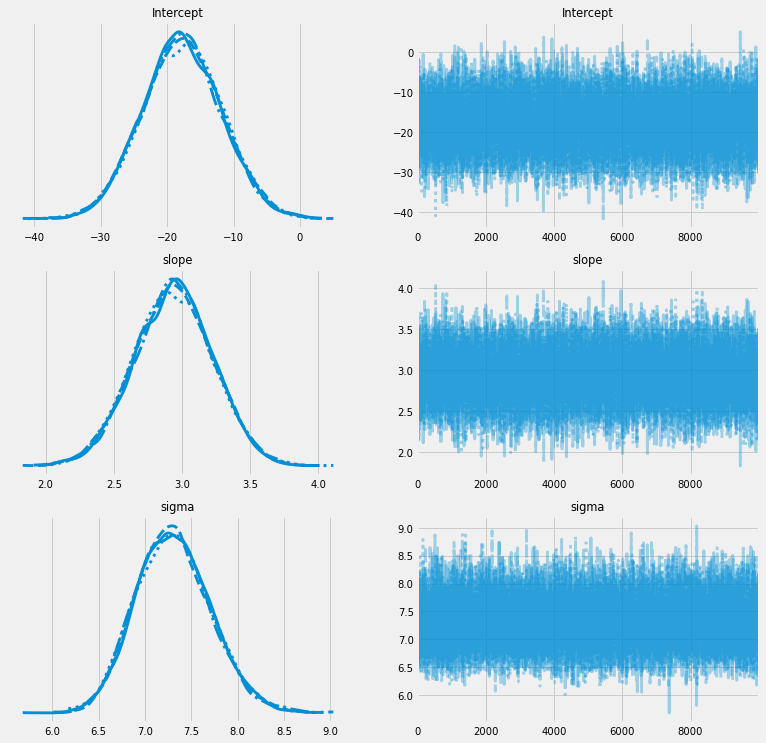

In [16]:
pm.traceplot(linear_trace_uninformed, figsize = (12, 12))

Notice that since the standard deviation of the prior in this example is very large, it has almost no effect. The intercept for the OLS model was -17.83, and the mean for the intercept's posterior distribution is -18. Despite having some effect, it was minimal. This is starkly different from the informed prior example. With the informed prior, the mean for the intercepts posterior is -7.4. The data is the same, and the mean of the prior is exactly the same; the only difference between the two priors in the informed and uniformed example is the standard deviations of each prior. The informed prior has a standard deviation of 5, and the uninformed prior has a standard deviation of 100.

Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\wjduq\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<AxesSubplot:title={'center':'Intercept'}>,
       <AxesSubplot:title={'center':'slope'}>,
       <AxesSubplot:title={'center':'sigma'}>], dtype=object)

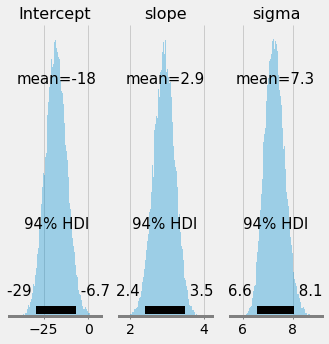

In [17]:
pm.plot_posterior(linear_trace_uninformed, figsize = (5, 5), kind = "hist")

C:\Users\wjduq\anaconda3\lib\site-packages\pymc3\plots\posteriorplot.py:59: DeprecationWarning: The `plot_posterior_predictive_glm` function will migrate to Arviz in a future release. 
Keep up to date with `ArviZ <https://arviz-devs.github.io/arviz/>`_ for future updates.
  warnings.warn(


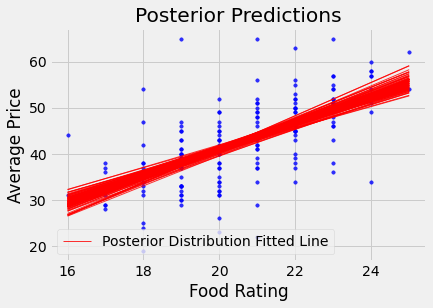

In [18]:
pm.plot_posterior_predictive_glm(linear_trace_uninformed, samples = 100, eval=np.linspace(16,25, 100), linewidth = 1, 
                                 color = "red", alpha = 0.8, label = "Posterior Distribution Fitted Line",
                                lm = lambda x, sample: sample["Intercept"] + sample["slope"] * x);
pyplot.scatter(NYCDf["Food"], y.values, s = 12, alpha = 0.8, c = "blue")
pyplot.title("Posterior Predictions")
pyplot.xlabel("Food Rating")
pyplot.ylabel("Average Price")
pyplot.legend()

Directly above you can see the original scatterplot with the possible posterior equations. Remember, the posterior is not the one "best" equation but rather a distribution.

In [19]:
bayes_prediction = linear_trace_uninformed["Intercept"] + linear_trace_uninformed["slope"] * 23

Text(0.5, 1.0, 'Posterior Prediction for Food Rating of 23')

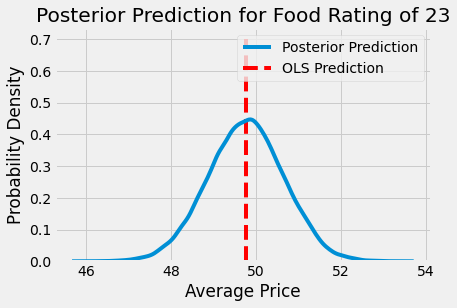

In [20]:
sn.kdeplot(bayes_prediction, label = 'Posterior Prediction')
pyplot.vlines(x = model[1] + model[0] * 23, ymin = 0, ymax = 0.7, label = 'OLS Prediction', colors = 'red', linestyles='--')
pyplot.legend()
pyplot.xlabel("Average Price")
pyplot.ylabel("Probability Density")
pyplot.title("Posterior Prediction for Food Rating of 23")

Prediction works the same way for an uninformed prior and as you can see, the mean of the Bayesian prediction distribution is almost exactly the same as the OLS predicted value.